<div style="background-color: darkslategray; color: white; padding: 15px; border-radius: 8px;">
    <center><h1 style="font-family: Arial, sans-serif;">Predicting Rare Species</h1></center>
    <center><h3 style="font-family: Arial, sans-serif;">Deep Learning Project</h3></center>
</div>

**<h3>Table of Contents</h3>**
* [1. Environment Setup](#1-environment-setup)
    * [1.1 Import Libraries](#11-import-libraries)
    * [1.2 Import Dataset](#12-import-dataset)
* [2. Exploratory Data Analysis](#2-exploratory-data-analysis)
    * [2.1 Visualizations](#21-visualizations)
    * [2.2 Import Dataset](#22-feature-engineering)
* [3. Splitting the Dataset](#3-splitting-the-dataset)
* [4. Splitting the Dataset](#4-preprocessing)
    * [4.1 Image Generator and Augmentation](#41-image-generator-and-augmentation)


<div class="alert alert-block alert-success">

# **1.** Environment Setup

<div>

## 1.1 Import Libraries

In [1]:
import keras_cv
print(keras_cv.__version__)

0.9.0


/Users/brunasimoes/Desktop/nova_ims/2_semester/Trimestral/deep_learning/deep-learning-project/.venv/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
import pandas as pd
from pathlib import Path
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow import keras
from tabulate import tabulate
from keras import regularizers
from classes import *
from functions import *

In [3]:
from tensorflow.keras import models
from tensorflow.keras import layers
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.applications.resnet50 import preprocess_input
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout, Input, Conv2D, MaxPooling2D, Flatten
from tensorflow.keras.preprocessing.image import ImageDataGenerator 
from tensorflow.keras.optimizers import Adam
from keras.metrics import AUC, F1Score, CategoricalAccuracy
from sklearn.metrics import f1_score, precision_score, recall_score

## 1.2 Import Dataset

The amount of data we have is not supported by GitHub (where we have our project stored). The solution is: create a folder named data and allocate the rare_species file inside it. The gitignore file makes sure this folder is not used when we are pulling or pushing changes but everyone needs to have it on their machines locally. A random seed was used to ensure that the splits stay the same. 

In [4]:
path = Path("data/rare_species")

In [5]:
# Import Metadata
metadata_path = Path("../data/rare_species/metadata.csv")
df = pd.read_csv(metadata_path)
df.head()

,rare_species_id,eol_content_id,eol_page_id,kingdom,phylum,family,file_path
0,75fd91cb-2881-41cd-88e6-de451e8b60e2,12853737,449393,animalia,mollusca,unionidae,mollusca_unionidae/12853737_449393_eol-full-si...
1,28c508bc-63ff-4e60-9c8f-1934367e1528,20969394,793083,animalia,chordata,geoemydidae,chordata_geoemydidae/20969394_793083_eol-full-...
2,00372441-588c-4af8-9665-29bee20822c0,28895411,319982,animalia,chordata,cryptobranchidae,chordata_cryptobranchidae/28895411_319982_eol-...
3,29cc6040-6af2-49ee-86ec-ab7d89793828,29658536,45510188,animalia,chordata,turdidae,chordata_turdidae/29658536_45510188_eol-full-s...
4,94004bff-3a33-4758-8125-bf72e6e57eab,21252576,7250886,animalia,chordata,indriidae,chordata_indriidae/21252576_7250886_eol-full-s...


In [6]:
df.shape # 11983 images

(11983, 7)

In [7]:
# Windows
# df["full_file_path"] = df["file_path"].apply(lambda x: os.path.join(path, x.replace("/", "\\")))

# Mac
df["full_file_path"] = df["file_path"].apply(lambda x: Path(x))
df

,rare_species_id,eol_content_id,eol_page_id,kingdom,phylum,family,file_path,full_file_path
0,75fd91cb-2881-41cd-88e6-de451e8b60e2,12853737,449393,animalia,mollusca,unionidae,mollusca_unionidae/12853737_449393_eol-full-si...,mollusca_unionidae/12853737_449393_eol-full-si...
1,28c508bc-63ff-4e60-9c8f-1934367e1528,20969394,793083,animalia,chordata,geoemydidae,chordata_geoemydidae/20969394_793083_eol-full-...,chordata_geoemydidae/20969394_793083_eol-full-...
2,00372441-588c-4af8-9665-29bee20822c0,28895411,319982,animalia,chordata,cryptobranchidae,chordata_cryptobranchidae/28895411_319982_eol-...,chordata_cryptobranchidae/28895411_319982_eol-...
3,29cc6040-6af2-49ee-86ec-ab7d89793828,29658536,45510188,animalia,chordata,turdidae,chordata_turdidae/29658536_45510188_eol-full-s...,chordata_turdidae/29658536_45510188_eol-full-s...
4,94004bff-3a33-4758-8125-bf72e6e57eab,21252576,7250886,animalia,chordata,indriidae,chordata_indriidae/21252576_7250886_eol-full-s...,chordata_indriidae/21252576_7250886_eol-full-s...
...,...,...,...,...,...,...,...,...
11978,1fa96ea5-32fa-4a25-b8d2-fa99f6e2cb89,29734618,1011315,animalia,chordata,leporidae,chordata_leporidae/29734618_1011315_eol-full-s...,chordata_leporidae/29734618_1011315_eol-full-s...
11979,628bf2b4-6ecc-4017-a8e6-4306849e0cfc,29972861,1056842,animalia,chordata,emydidae,chordata_emydidae/29972861_1056842_eol-full-si...,chordata_emydidae/29972861_1056842_eol-full-si...
11980,0ecfdec9-b1cd-4d43-96fc-2f8889ec1ad9,30134195,52572074,animalia,chordata,dasyatidae,chordata_dasyatidae/30134195_52572074_eol-full...,chordata_dasyatidae/30134195_52572074_eol-full...
11981,27fdb1e9-c5fb-459a-8b6a-6fb222b1c512,9474963,46559139,animalia,chordata,mustelidae,chordata_mustelidae/9474963_46559139_eol-full-...,chordata_mustelidae/9474963_46559139_eol-full-...


In [8]:
pd.set_option('display.max_colwidth', None)
print(df['full_file_path'])

0               mollusca_unionidae/12853737_449393_eol-full-size-copy.jpg
1             chordata_geoemydidae/20969394_793083_eol-full-size-copy.jpg
2        chordata_cryptobranchidae/28895411_319982_eol-full-size-copy.jpg
3              chordata_turdidae/29658536_45510188_eol-full-size-copy.jpg
4              chordata_indriidae/21252576_7250886_eol-full-size-copy.jpg
                                       ...                               
11978          chordata_leporidae/29734618_1011315_eol-full-size-copy.jpg
11979           chordata_emydidae/29972861_1056842_eol-full-size-copy.jpg
11980        chordata_dasyatidae/30134195_52572074_eol-full-size-copy.jpg
11981         chordata_mustelidae/9474963_46559139_eol-full-size-copy.jpg
11982            chordata_lemuridae/9465817_326525_eol-full-size-copy.jpg
Name: full_file_path, Length: 11983, dtype: object


<div class="alert alert-block alert-success">

# **2.** Exploratory Data Analysis

<div>

## 2.1 Visualizations

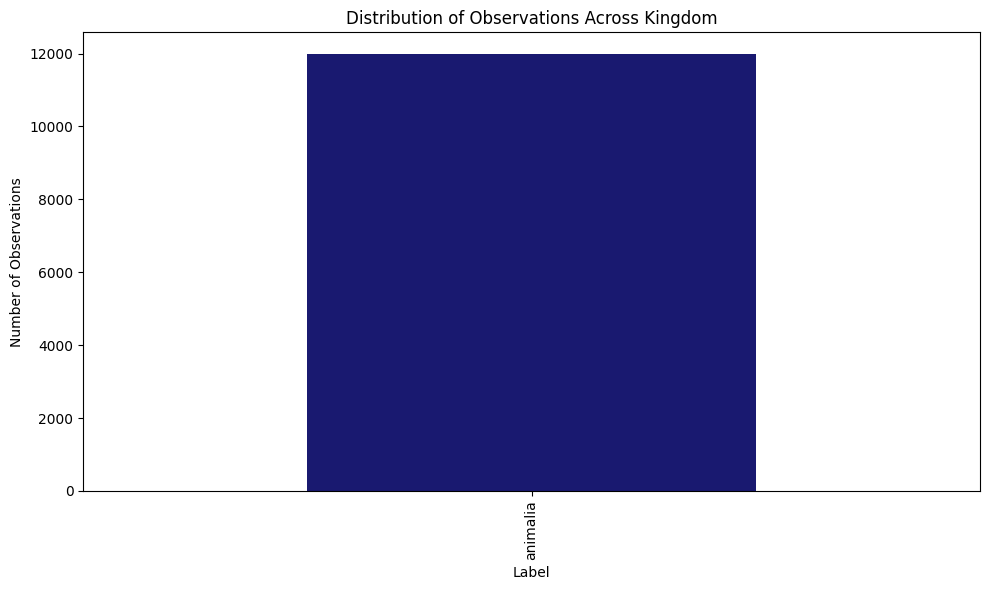

In [9]:
kingdom_counts = df['kingdom'].value_counts()
plot_graph(title='Distribution of Observations Across Kingdom', xlabel='Kingdom', ylabel='Number of Observations',  counts=kingdom_counts)

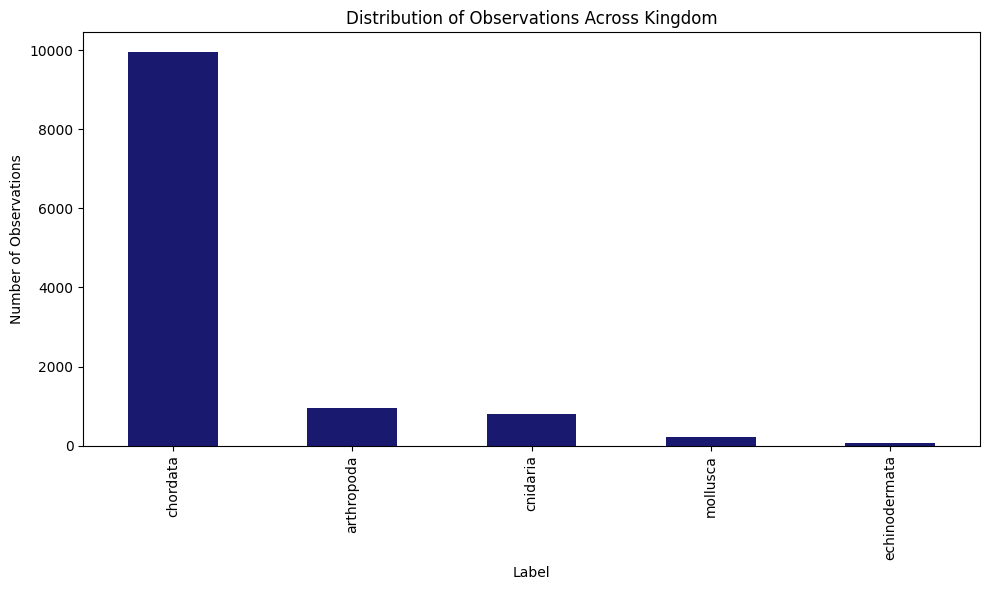

In [10]:
phylum_counts = df['phylum'].value_counts()
plot_graph(title='Distribution of Observations Across Phylum', xlabel='Phylum', ylabel='Number of Observations',  counts=phylum_counts)

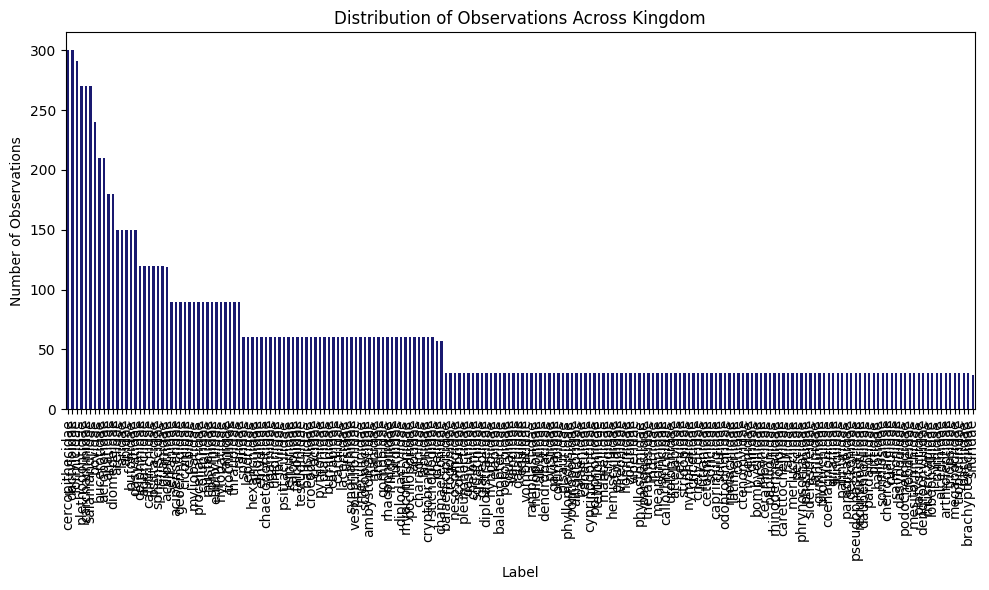

In [11]:
family_counts = df['family'].value_counts()
plot_graph(title='Distribution of Observations Across Family', xlabel='Family', ylabel='Number of Observations',  counts=family_counts)

In [12]:
family_counts = df["family"].value_counts(normalize=True)*100

df_family_proportions = pd.DataFrame({
    "Family": family_counts.index,
    "Proportion (%)": family_counts.values  
})

df_family_proportions # 202 different families

,Family,Proportion (%)
0,cercopithecidae,2.503547
1,dactyloidae,2.503547
2,formicidae,2.428440
3,plethodontidae,2.253192
4,carcharhinidae,2.253192
...,...,...
197,megapodiidae,0.250355
198,tropiduridae,0.250355
199,parulidae,0.250355
200,brachypteraciidae,0.250355


In [13]:
num_families_025 = int((df_family_proportions["Proportion (%)"] <= 0.2505).sum())
num_families_025 # 118 families have less than 0.2505% of images

118

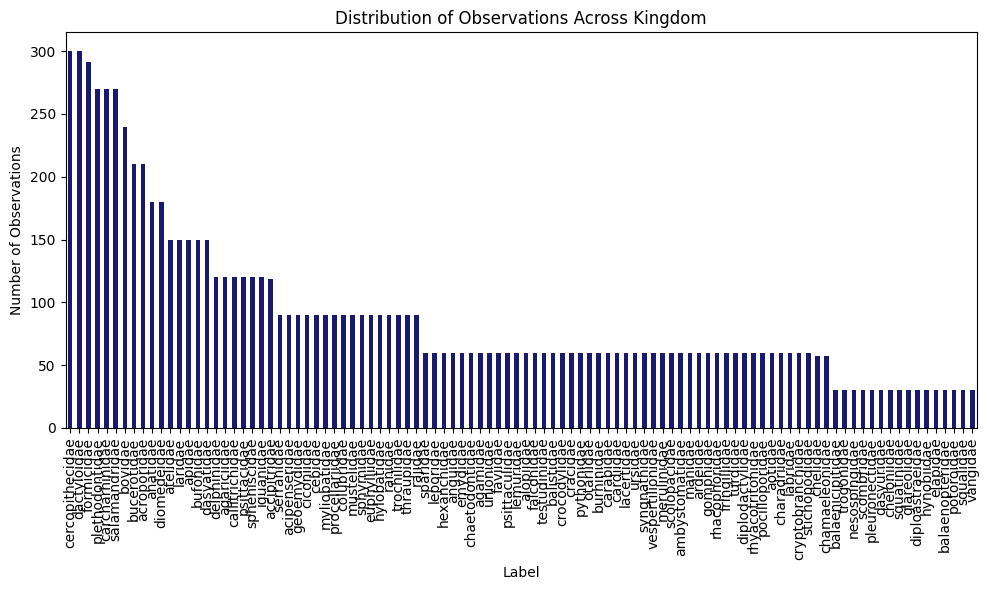

In [14]:
top_100_families = df['family'].value_counts().nlargest(100)
plot_graph(title='Distribution of Observations Across Top 100 Families', xlabel='Family', ylabel='Number of Observations',  counts=top_100_families)

In [15]:
top_84_family_proportion_sum = df_family_proportions.iloc[:84]["Proportion (%)"].sum()
top_84_family_proportion_sum # although 118 families represent less than 0.25% of the dataset, the 84 that have >0.25% represent only 70.46% of the dataset

np.float64(70.46649420011681)

## 2.2 Feature Engineering

In [16]:
# is it better to predict phylum and then family or a concatenation of the two?

In [17]:
df["phylum_family"] = df["phylum"] + "_" + df["family"]
df

,rare_species_id,eol_content_id,eol_page_id,kingdom,phylum,family,file_path,full_file_path,phylum_family
0,75fd91cb-2881-41cd-88e6-de451e8b60e2,12853737,449393,animalia,mollusca,unionidae,mollusca_unionidae/12853737_449393_eol-full-size-copy.jpg,mollusca_unionidae/12853737_449393_eol-full-size-copy.jpg,mollusca_unionidae
1,28c508bc-63ff-4e60-9c8f-1934367e1528,20969394,793083,animalia,chordata,geoemydidae,chordata_geoemydidae/20969394_793083_eol-full-size-copy.jpg,chordata_geoemydidae/20969394_793083_eol-full-size-copy.jpg,chordata_geoemydidae
2,00372441-588c-4af8-9665-29bee20822c0,28895411,319982,animalia,chordata,cryptobranchidae,chordata_cryptobranchidae/28895411_319982_eol-full-size-copy.jpg,chordata_cryptobranchidae/28895411_319982_eol-full-size-copy.jpg,chordata_cryptobranchidae
3,29cc6040-6af2-49ee-86ec-ab7d89793828,29658536,45510188,animalia,chordata,turdidae,chordata_turdidae/29658536_45510188_eol-full-size-copy.jpg,chordata_turdidae/29658536_45510188_eol-full-size-copy.jpg,chordata_turdidae
4,94004bff-3a33-4758-8125-bf72e6e57eab,21252576,7250886,animalia,chordata,indriidae,chordata_indriidae/21252576_7250886_eol-full-size-copy.jpg,chordata_indriidae/21252576_7250886_eol-full-size-copy.jpg,chordata_indriidae
...,...,...,...,...,...,...,...,...,...
11978,1fa96ea5-32fa-4a25-b8d2-fa99f6e2cb89,29734618,1011315,animalia,chordata,leporidae,chordata_leporidae/29734618_1011315_eol-full-size-copy.jpg,chordata_leporidae/29734618_1011315_eol-full-size-copy.jpg,chordata_leporidae
11979,628bf2b4-6ecc-4017-a8e6-4306849e0cfc,29972861,1056842,animalia,chordata,emydidae,chordata_emydidae/29972861_1056842_eol-full-size-copy.jpg,chordata_emydidae/29972861_1056842_eol-full-size-copy.jpg,chordata_emydidae
11980,0ecfdec9-b1cd-4d43-96fc-2f8889ec1ad9,30134195,52572074,animalia,chordata,dasyatidae,chordata_dasyatidae/30134195_52572074_eol-full-size-copy.jpg,chordata_dasyatidae/30134195_52572074_eol-full-size-copy.jpg,chordata_dasyatidae
11981,27fdb1e9-c5fb-459a-8b6a-6fb222b1c512,9474963,46559139,animalia,chordata,mustelidae,chordata_mustelidae/9474963_46559139_eol-full-size-copy.jpg,chordata_mustelidae/9474963_46559139_eol-full-size-copy.jpg,chordata_mustelidae


In [18]:
family_phylum_counts = df.groupby("phylum")["family"].nunique()

In [19]:
family_phylum_counts # the phylum with the most families is chordata

phylum
arthropoda        17
chordata         166
cnidaria          13
echinodermata      1
mollusca           5
Name: family, dtype: int64

In [20]:
anomaly_counts = df.groupby("family")["phylum"].nunique()

In [21]:
anomaly_counts.value_counts() # there are no families that belong to more than 1 phylum

phylum
1    202
Name: count, dtype: int64

In [22]:
phylum_family_counts = df["phylum_family"].value_counts(normalize=True)*100

df_phylum_family_proportions = pd.DataFrame({
    "phylum_family": phylum_family_counts.index,
    "Proportion (%)": phylum_family_counts.values.round(4)  
})

df_phylum_family_proportions # 202 different families

,phylum_family,Proportion (%)
0,chordata_cercopithecidae,2.5035
1,chordata_dactyloidae,2.5035
2,arthropoda_formicidae,2.4284
3,chordata_plethodontidae,2.2532
4,chordata_carcharhinidae,2.2532
...,...,...
197,chordata_megapodiidae,0.2504
198,chordata_tropiduridae,0.2504
199,chordata_parulidae,0.2504
200,chordata_brachypteraciidae,0.2504


<div class="alert alert-block alert-success">

# **3.** Splitting the Dataset

<div>

In [23]:
# Split the data into training, validation, and testing sets
train_df, test_valid_df = train_test_split(df, test_size=0.3, shuffle=True, random_state=42, stratify=df['family'])
valid_df, test_df = train_test_split(test_valid_df, test_size=0.5, shuffle=True, random_state=42, stratify=test_valid_df['family'])

In [24]:
train_df_sampled, _ = train_test_split(train_df, test_size=0.5, shuffle=True, random_state=42, stratify=train_df['family'])

In [25]:
image_base_path = Path("../data/rare_species")
metadata_path = image_base_path / "metadata.csv"
base_output_dir = image_base_path

In [26]:
organize_split(image_base_path=image_base_path, base_output_dir=base_output_dir, split_df=train_df_sampled, split_name="train_sampled")
organize_split(image_base_path=image_base_path, base_output_dir=base_output_dir, split_df=valid_df, split_name="val")
organize_split(image_base_path=image_base_path, base_output_dir=base_output_dir, split_df=test_df, split_name="test")

Not found: ../data/rare_species/chordata_balaenopteridae/21756536_46559441_eol-full-size-copy.jpg
Not found: ../data/rare_species/chordata_carcharhinidae/28758159_46559811_eol-full-size-copy.jpg
Not found: ../data/rare_species/chordata_ranidae/20922676_1019689_eol-full-size-copy.jpg
Not found: ../data/rare_species/chordata_leporidae/29734641_1011315_eol-full-size-copy.jpg
Not found: ../data/rare_species/chordata_cyprinodontidae/22969020_1012078_eol-full-size-copy.jpg
Not found: ../data/rare_species/cnidaria_diploastraeidae/14075093_45277122_eol-full-size-copy.jpg
Not found: ../data/rare_species/chordata_atelidae/29865982_4472389_eol-full-size-copy.jpg
Not found: ../data/rare_species/chordata_hexanchidae/22181471_46560151_eol-full-size-copy.jpg
Not found: ../data/rare_species/chordata_testudinidae/20690633_794293_eol-full-size-copy.jpg
Not found: ../data/rare_species/arthropoda_platystictidae/29911928_132324_eol-full-size-copy.jpg
Not found: ../data/rare_species/arthropoda_formicidae/29

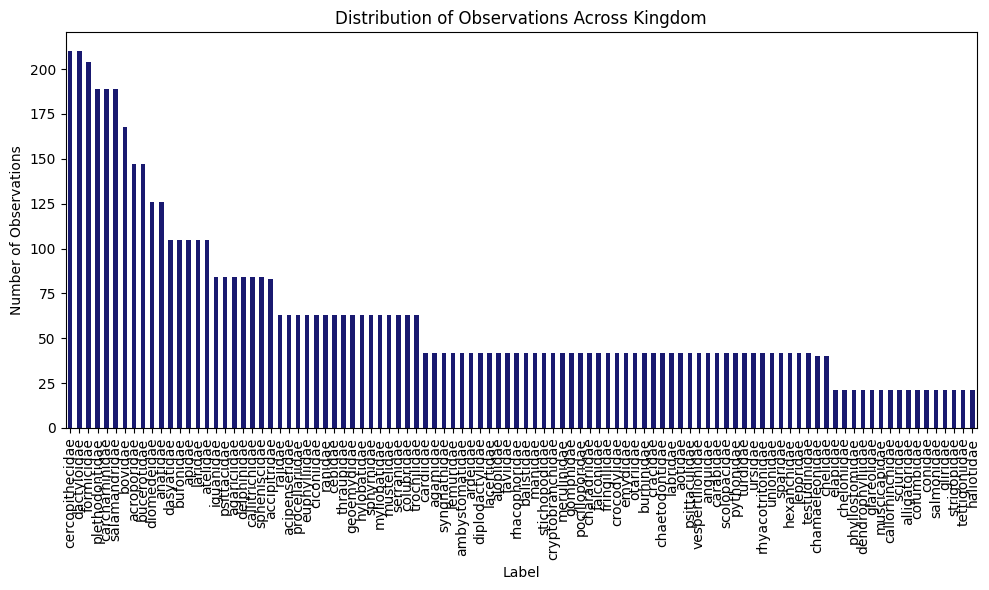

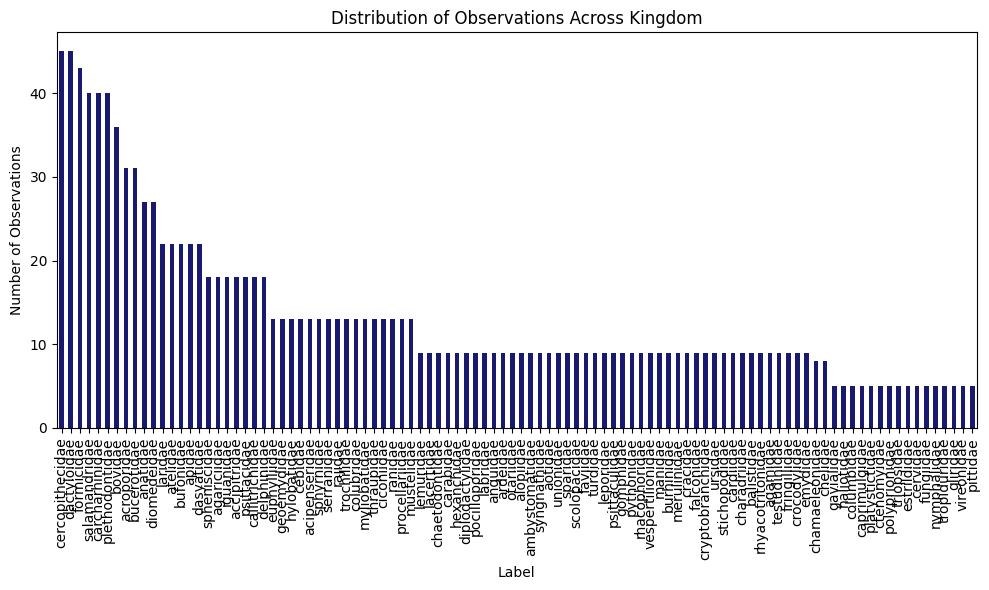

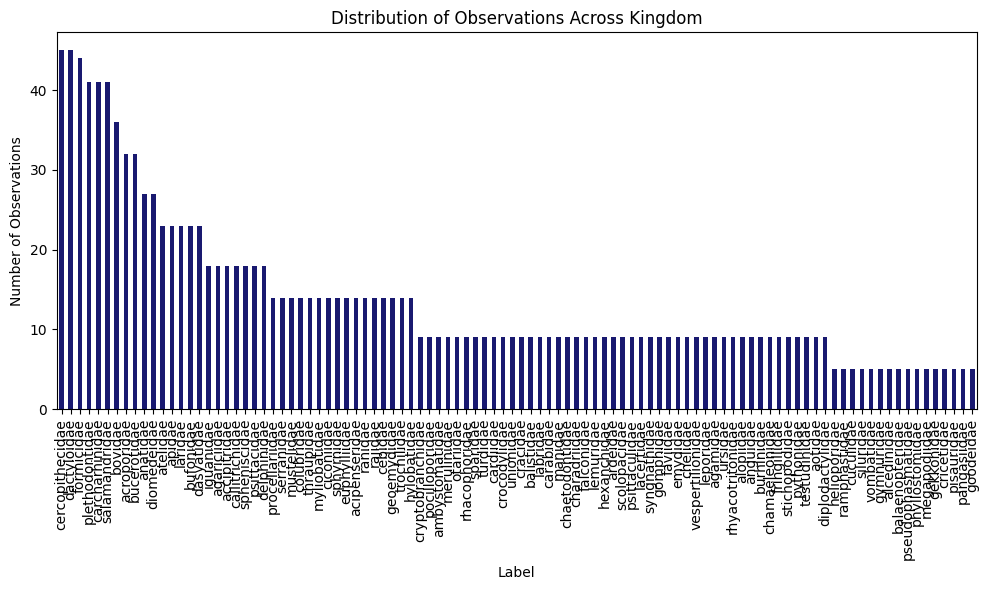

In [27]:
train_df_counts = train_df['family'].value_counts().nlargest(100)
plot_graph(title='Distribution of Observations - Train Dataset', xlabel='Family', ylabel='Number of Observations',  counts=train_df_counts )

valid_df_counts = valid_df['family'].value_counts().nlargest(100)
plot_graph(title='Distribution of Observations - Validation Dataset', xlabel='Family', ylabel='Number of Observations',  counts=valid_df_counts )

test_df_counts = test_df['family'].value_counts().nlargest(100)
plot_graph(title='Distribution of Observations - Test Dataset', xlabel='Family', ylabel='Number of Observations',  counts=test_df_counts )

In [28]:
print(f"Training samples: {len(train_df)}")
print(f"Validation samples: {len(valid_df)}")
print(f"Testing samples: {len(test_df)}")

Training samples: 8388
Validation samples: 1797
Testing samples: 1798


<div class="alert alert-block alert-success">

# **4.** Preprocessing

<div>

- Normalizes pixel values (e.g., rescaling from [0,255] to [0,1]).
- Resizes images to a fixed size (e.g., 224x224 pixels).
- Applies augmentation (only during training).
- Converts images to batches (e.g., batch_size=32 loads 32 images at a time).

In [29]:
num_images = 32 ##
rows, cols = 4, 4 ##

# plot_batch(train_ds, class_names=class_names, num_images=num_images, rows=rows, cols=cols)

## 4.1 Minority classes

In [30]:
minority_class = train_df['family'].value_counts()[train_df['family'].value_counts() < 25].index
minority_class=minority_class.to_list()

## 4.1 Augmentations

In [30]:
augmentations_to_test = [
    "none",
    "light",
    "medium",
    "heavy",
    "grayscale",
    "randaugment",
    "mixup",
    "cutmix"]

##### Loop

In [39]:
layers = [Conv2D(16, (3, 3), activation="relu", input_shape=(224, 224, 3)),
          MaxPooling2D((2, 2)),
          Conv2D(32, (3, 3), activation="relu"),
          MaxPooling2D((2, 2)),
          Conv2D(64, (3, 3), activation="relu"),
          MaxPooling2D((2, 2)),
          Flatten(),
          Dense(512, activation="relu", kernel_regularizer=regularizers.l2(0.001)),
          Dropout(0.5),
          Dense(202, activation="softmax")
          ]

/Users/brunasimoes/Desktop/nova_ims/2_semester/Trimestral/deep_learning/deep-learning-project/.venv/lib/python3.11/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [42]:
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

# Callbacks to reduce overfitting
callbacks = [
    EarlyStopping(
        monitor='val_loss',
        patience=5,           # Stop if val_loss doesn’t improve after 5 epochs
        restore_best_weights=True
    ),
    ReduceLROnPlateau(
        monitor='val_loss',
        factor=0.5,
        patience=3,           # Reduce LR if no improvement after 3 epochs
        min_lr=1e-6,
        verbose=1
    )
]


In [ ]:
# Initialize the preprocessor
pre = Preprocessor(image_size=(224, 224), batch_size=32)

# Store results
results = {}

# Loop through each augmentation
for aug in augmentations_to_test:
    print(f"\nTraining with augmentation: {aug}")

    # Load datasets
    train_sampled_ds, class_names = pre.load_img(
        data_dir="../data/rare_species/train_sampled",
        minority_class=minority_class,
        augment=aug
    )

    val_ds, _ = pre.load_img(
        data_dir="../data/rare_species/val",
        minority_class=minority_class,
        augment=None
    )

    # Build a fresh model (you should define this function)
    model = build_sequential_model(list_of_layers=layers)

    # Compile
    model.compile(
        optimizer="adam",
        loss="categorical_crossentropy",
        metrics=["accuracy"]
    )

    # Train
    history = model.fit(
        train_sampled_ds,
        validation_data=val_ds,
        epochs=15,  
        verbose=1,
        callbacks=callbacks
    )


    # Predict entire validation set at once
    preds = model.predict(val_ds)
    y_pred = np.argmax(preds, axis=1)

    # Extract true labels in order
    y_true = np.concatenate([np.argmax(y.numpy(), axis=1) for _, y in val_ds])

    # Compute metrics
    f1_macro = f1_score(y_true, y_pred, average='macro')
    f1_weighted = f1_score(y_true, y_pred, average='weighted')
    precision = precision_score(y_true, y_pred, average='weighted')
    recall = recall_score(y_true, y_pred, average='weighted')

    # Store in results
    results[aug] = {
        "val_accuracy": history.history["val_accuracy"][-1],
        "f1_macro": f1_macro,
        "f1_weighted": f1_weighted,
        "precision": precision,
        "recall": recall
    }

    print(f"Finished '{aug}'")
    print(f"  Accuracy:      {results[aug]['val_accuracy']:.4f}")
    print(f"  F1 (macro):    {results[aug]['f1_macro']:.4f}")
    print(f"  F1 (weighted): {results[aug]['f1_weighted']:.4f}")
    print(f"  Precision:     {results[aug]['precision']:.4f}")
    print(f"  Recall:        {results[aug]['recall']:.4f}")



sorted_results = sorted(
    results.items(),
    key=lambda item: item[1]["val_accuracy"],
    reverse=True
)
table_data = []
for aug, metrics in sorted_results:
    row = [aug] + [f"{metrics[k]:.4f}" for k in ["val_accuracy", "f1_macro", "f1_weighted", "precision", "recall"]]
    table_data.append(row)

headers = ["Augmentation", "Val Accuracy", "F1 (Macro)", "F1 (Weighted)", "Precision", "Recall"]
print(tabulate(table_data, headers=headers, tablefmt="fancy_grid"))



Training with augmentation: none
Found 4194 files belonging to 202 classes.
Found 1797 files belonging to 202 classes.
Epoch 1/15
132/132 ━━━━━━━━━━━━━━━━━━━━ 69s 516ms/step - accuracy: 0.1196 - loss: 4.4843 - val_accuracy: 0.1080 - val_loss: 4.7798 - learning_rate: 0.0010
Epoch 2/15
132/132 ━━━━━━━━━━━━━━━━━━━━ 55s 417ms/step - accuracy: 0.1477 - loss: 4.2342 - val_accuracy: 0.1080 - val_loss: 4.9787 - learning_rate: 0.0010
Epoch 3/15
132/132 ━━━━━━━━━━━━━━━━━━━━ 51s 385ms/step - accuracy: 0.1736 - loss: 4.0810 - val_accuracy: 0.1191 - val_loss: 5.0929 - learning_rate: 0.0010
Epoch 4/15
132/132 ━━━━━━━━━━━━━━━━━━━━ 0s 295ms/step - accuracy: 0.2183 - loss: 3.8647
Epoch 4: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.
132/132 ━━━━━━━━━━━━━━━━━━━━ 50s 379ms/step - accuracy: 0.2183 - loss: 3.8649 - val_accuracy: 0.1224 - val_loss: 5.2057 - learning_rate: 0.0010
Epoch 5/15
132/132 ━━━━━━━━━━━━━━━━━━━━ 55s 417ms/step - accuracy: 0.2595 - loss: 3.6052 - val_accuracy: 0.

/Users/brunasimoes/Desktop/nova_ims/2_semester/Trimestral/deep_learning/deep-learning-project/.venv/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Found 1797 files belonging to 202 classes.
Epoch 1/15
132/132 ━━━━━━━━━━━━━━━━━━━━ 87s 648ms/step - accuracy: 0.0802 - loss: 4.8593 - val_accuracy: 0.0896 - val_loss: 4.8654 - learning_rate: 0.0010
Epoch 2/15
132/132 ━━━━━━━━━━━━━━━━━━━━ 57s 431ms/step - accuracy: 0.1026 - loss: 4.6330 - val_accuracy: 0.0974 - val_loss: 4.9450 - learning_rate: 0.0010
Epoch 3/15
132/132 ━━━━━━━━━━━━━━━━━━━━ 55s 417ms/step - accuracy: 0.1289 - loss: 4.4350 - val_accuracy: 0.0929 - val_loss: 5.2496 - learning_rate: 0.0010
Epoch 4/15
132/132 ━━━━━━━━━━━━━━━━━━━━ 0s 336ms/step - accuracy: 0.1567 - loss: 4.2422
Epoch 4: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.
132/132 ━━━━━━━━━━━━━━━━━━━━ 56s 425ms/step - accuracy: 0.1568 - loss: 4.2422 - val_accuracy: 0.0940 - val_loss: 6.0293 - learning_rate: 0.0010
Epoch 5/15
132/132 ━━━━━━━━━━━━━━━━━━━━ 55s 415ms/step - accuracy: 0.1982 - loss: 4.0072 - val_accuracy: 0.0818 - val_loss: 6.1884 - learning_rate: 5.0000e-04
Epoch 6/15
132/132 ━━━━━━

/Users/brunasimoes/Desktop/nova_ims/2_semester/Trimestral/deep_learning/deep-learning-project/.venv/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Found 1797 files belonging to 202 classes.
Epoch 1/15
132/132 ━━━━━━━━━━━━━━━━━━━━ 88s 655ms/step - accuracy: 0.0768 - loss: 4.8396 - val_accuracy: 0.0907 - val_loss: 5.1700 - learning_rate: 0.0010
Epoch 2/15
132/132 ━━━━━━━━━━━━━━━━━━━━ 56s 424ms/step - accuracy: 0.0933 - loss: 4.6315 - val_accuracy: 0.1052 - val_loss: 5.1327 - learning_rate: 0.0010
Epoch 3/15
132/132 ━━━━━━━━━━━━━━━━━━━━ 45s 343ms/step - accuracy: 0.1201 - loss: 4.4510 - val_accuracy: 0.0952 - val_loss: 5.7816 - learning_rate: 0.0010
Epoch 4/15
132/132 ━━━━━━━━━━━━━━━━━━━━ 44s 335ms/step - accuracy: 0.1469 - loss: 4.2972 - val_accuracy: 0.1046 - val_loss: 5.6895 - learning_rate: 0.0010
Epoch 5/15
132/132 ━━━━━━━━━━━━━━━━━━━━ 0s 266ms/step - accuracy: 0.1790 - loss: 4.1148
Epoch 5: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.
132/132 ━━━━━━━━━━━━━━━━━━━━ 45s 339ms/step - accuracy: 0.1790 - loss: 4.1154 - val_accuracy: 0.0968 - val_loss: 6.0274 - learning_rate: 0.0010
Epoch 6/15
132/132 ━━━━━━━━━━

/Users/brunasimoes/Desktop/nova_ims/2_semester/Trimestral/deep_learning/deep-learning-project/.venv/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Found 1797 files belonging to 202 classes.
Epoch 1/15
132/132 ━━━━━━━━━━━━━━━━━━━━ 86s 640ms/step - accuracy: 0.0680 - loss: 5.0207 - val_accuracy: 0.0924 - val_loss: 4.9362 - learning_rate: 0.0010
Epoch 2/15
132/132 ━━━━━━━━━━━━━━━━━━━━ 55s 419ms/step - accuracy: 0.0790 - loss: 4.8113 - val_accuracy: 0.0902 - val_loss: 5.0598 - learning_rate: 0.0010
Epoch 3/15
132/132 ━━━━━━━━━━━━━━━━━━━━ 55s 414ms/step - accuracy: 0.1043 - loss: 4.6579 - val_accuracy: 0.0918 - val_loss: 5.3315 - learning_rate: 0.0010
Epoch 4/15
132/132 ━━━━━━━━━━━━━━━━━━━━ 0s 323ms/step - accuracy: 0.1260 - loss: 4.4929
Epoch 4: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.
132/132 ━━━━━━━━━━━━━━━━━━━━ 54s 413ms/step - accuracy: 0.1260 - loss: 4.4927 - val_accuracy: 0.0846 - val_loss: 5.4662 - learning_rate: 0.0010
Epoch 5/15
132/132 ━━━━━━━━━━━━━━━━━━━━ 54s 407ms/step - accuracy: 0.1636 - loss: 4.2485 - val_accuracy: 0.0863 - val_loss: 5.5276 - learning_rate: 5.0000e-04
Epoch 6/15
132/132 ━━━━━━

/Users/brunasimoes/Desktop/nova_ims/2_semester/Trimestral/deep_learning/deep-learning-project/.venv/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Found 1797 files belonging to 202 classes.
Epoch 1/15
132/132 ━━━━━━━━━━━━━━━━━━━━ 75s 565ms/step - accuracy: 0.1131 - loss: 4.6083 - val_accuracy: 0.1096 - val_loss: 4.7330 - learning_rate: 0.0010
Epoch 2/15
132/132 ━━━━━━━━━━━━━━━━━━━━ 55s 418ms/step - accuracy: 0.1353 - loss: 4.3023 - val_accuracy: 0.1208 - val_loss: 4.7661 - learning_rate: 0.0010
Epoch 3/15
132/132 ━━━━━━━━━━━━━━━━━━━━ 42s 317ms/step - accuracy: 0.1653 - loss: 4.1138 - val_accuracy: 0.1185 - val_loss: 4.8384 - learning_rate: 0.0010
Epoch 4/15
132/132 ━━━━━━━━━━━━━━━━━━━━ 0s 280ms/step - accuracy: 0.1982 - loss: 3.9205
Epoch 4: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.
132/132 ━━━━━━━━━━━━━━━━━━━━ 47s 356ms/step - accuracy: 0.1982 - loss: 3.9205 - val_accuracy: 0.1219 - val_loss: 4.9820 - learning_rate: 0.0010
Epoch 5/15
132/132 ━━━━━━━━━━━━━━━━━━━━ 50s 377ms/step - accuracy: 0.2294 - loss: 3.7182 - val_accuracy: 0.1302 - val_loss: 5.0620 - learning_rate: 5.0000e-04
Epoch 6/15
132/132 ━━━━━━

/Users/brunasimoes/Desktop/nova_ims/2_semester/Trimestral/deep_learning/deep-learning-project/.venv/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Found 1797 files belonging to 202 classes.
Epoch 1/15
132/132 ━━━━━━━━━━━━━━━━━━━━ 72s 534ms/step - accuracy: 0.0351 - loss: 18.0615 - val_accuracy: 0.0673 - val_loss: 5.0115 - learning_rate: 0.0010
Epoch 2/15
132/132 ━━━━━━━━━━━━━━━━━━━━ 52s 397ms/step - accuracy: 0.0433 - loss: 5.2721 - val_accuracy: 0.0668 - val_loss: 4.9482 - learning_rate: 0.0010
Epoch 3/15
132/132 ━━━━━━━━━━━━━━━━━━━━ 51s 388ms/step - accuracy: 0.0507 - loss: 5.1963 - val_accuracy: 0.0801 - val_loss: 4.9176 - learning_rate: 0.0010
Epoch 4/15
132/132 ━━━━━━━━━━━━━━━━━━━━ 52s 395ms/step - accuracy: 0.0587 - loss: 5.1548 - val_accuracy: 0.0768 - val_loss: 4.9389 - learning_rate: 0.0010
Epoch 5/15
132/132 ━━━━━━━━━━━━━━━━━━━━ 51s 384ms/step - accuracy: 0.0554 - loss: 5.0113 - val_accuracy: 0.0840 - val_loss: 4.9077 - learning_rate: 0.0010
Epoch 6/15
132/132 ━━━━━━━━━━━━━━━━━━━━ 44s 337ms/step - accuracy: 0.0607 - loss: 5.0737 - val_accuracy: 0.0846 - val_loss: 4.9274 - learning_rate: 0.0010
Epoch 7/15
132/132 ━━━━━━━

/Users/brunasimoes/Desktop/nova_ims/2_semester/Trimestral/deep_learning/deep-learning-project/.venv/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Found 1797 files belonging to 202 classes.
Epoch 1/15
132/132 ━━━━━━━━━━━━━━━━━━━━ 54s 403ms/step - accuracy: 0.0951 - loss: 4.7395 - val_accuracy: 0.1074 - val_loss: 4.7863 - learning_rate: 0.0010
Epoch 2/15
132/132 ━━━━━━━━━━━━━━━━━━━━ 42s 321ms/step - accuracy: 0.1205 - loss: 4.4751 - val_accuracy: 0.1135 - val_loss: 4.7736 - learning_rate: 0.0010
Epoch 3/15
132/132 ━━━━━━━━━━━━━━━━━━━━ 41s 311ms/step - accuracy: 0.1547 - loss: 4.2980 - val_accuracy: 0.1119 - val_loss: 4.9295 - learning_rate: 0.0010
Epoch 4/15
132/132 ━━━━━━━━━━━━━━━━━━━━ 41s 309ms/step - accuracy: 0.1868 - loss: 4.1010 - val_accuracy: 0.1063 - val_loss: 5.1182 - learning_rate: 0.0010
Epoch 5/15
132/132 ━━━━━━━━━━━━━━━━━━━━ 0s 245ms/step - accuracy: 0.2184 - loss: 4.0121
Epoch 5: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.
132/132 ━━━━━━━━━━━━━━━━━━━━ 41s 313ms/step - accuracy: 0.2184 - loss: 4.0122 - val_accuracy: 0.1135 - val_loss: 5.1183 - learning_rate: 0.0010
Epoch 6/15
132/132 ━━━━━━━━━━

/Users/brunasimoes/Desktop/nova_ims/2_semester/Trimestral/deep_learning/deep-learning-project/.venv/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Found 1797 files belonging to 202 classes.
Epoch 1/15
132/132 ━━━━━━━━━━━━━━━━━━━━ 56s 420ms/step - accuracy: 0.0924 - loss: 4.8959 - val_accuracy: 0.1046 - val_loss: 4.7641 - learning_rate: 0.0010
Epoch 2/15
132/132 ━━━━━━━━━━━━━━━━━━━━ 42s 321ms/step - accuracy: 0.1062 - loss: 4.6745 - val_accuracy: 0.1063 - val_loss: 4.8209 - learning_rate: 0.0010
Epoch 3/15
132/132 ━━━━━━━━━━━━━━━━━━━━ 41s 314ms/step - accuracy: 0.1223 - loss: 4.5560 - val_accuracy: 0.1135 - val_loss: 4.8349 - learning_rate: 0.0010
Epoch 4/15
132/132 ━━━━━━━━━━━━━━━━━━━━ 0s 245ms/step - accuracy: 0.1480 - loss: 4.4451
Epoch 4: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.
132/132 ━━━━━━━━━━━━━━━━━━━━ 41s 313ms/step - accuracy: 0.1480 - loss: 4.4453 - val_accuracy: 0.1024 - val_loss: 4.9351 - learning_rate: 0.0010
Epoch 5/15
132/132 ━━━━━━━━━━━━━━━━━━━━ 47s 359ms/step - accuracy: 0.1726 - loss: 4.3232 - val_accuracy: 0.1074 - val_loss: 4.8905 - learning_rate: 5.0000e-04
Epoch 6/15
132/132 ━━━━━━

/Users/brunasimoes/Desktop/nova_ims/2_semester/Trimestral/deep_learning/deep-learning-project/.venv/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


## 4.2 Class Imbalance

<div class="alert alert-block alert-success">

# **5.** Models

<div>

## Sequential

In [33]:
layers = [Conv2D(16, (3, 3), activation="relu", input_shape=(224, 224, 3)),
          MaxPooling2D((2, 2)),
          Conv2D(32, (3, 3), activation="relu"),
          MaxPooling2D((2, 2)),
          Conv2D(64, (3, 3), activation="relu"),
          MaxPooling2D((2, 2)),
          Flatten(),
          Dense(512, activation="relu", kernel_regularizer=regularizers.l2(0.001)),
          Dense(202, activation="softmax")
          ]

/Users/brunasimoes/Desktop/nova_ims/2_semester/Trimestral/deep_learning/deep-learning-project/.venv/lib/python3.11/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [79]:
first_sequential_model = build_sequential_model(list_of_layers=layers)
first_sequential_model.summary()

Model: "sequential_45"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_3 (Conv2D)               │ (None, 222, 222, 16)   │           448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 111, 111, 16)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 109, 109, 32)   │         4,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 54, 54, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 52, 52, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_5 (MaxPooling2D)  │ (None, 26, 26, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 43264)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 512)            │    22,151,680 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 202)            │       103,626 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 22,278,890 (84.99 MB)

 Trainable params: 22,278,890 (84.99 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
n_epochs = 1 ##
batch_size = 32 ##
initial_lr = 0.01 ##
final_lr = 0.001 ##

verbose = 1
metrics = [
    CategoricalAccuracy(name="accuracy"),
    AUC(name="auc"),
    F1Score(average="macro", name="f1_score")
]

In [34]:
my_scheduler_fn = lr_scheduler(initial_lr, final_lr, n_epochs)
callbacks = get_callbacks(
    checkpoint_file_path="checkpoints/model.keras",
    metrics_file_path="logs/run1.csv",
    lr_scheduler=my_scheduler_fn
)

first_sequential_model.compile(optimizer='rmsprop', loss= 'categorical_crossentropy', metrics= metrics)
history = first_sequential_model.fit(train_ds, epochs= n_epochs, verbose= 1, batch_size = batch_size, validation_data= val_ds, callbacks=callbacks)

263/263 ━━━━━━━━━━━━━━━━━━━━ 147s 557ms/step - accuracy: 0.0695 - auc: 0.6845 - f1_score: 0.0064 - loss: 5.6305 - val_accuracy: 0.0690 - val_auc: 0.6920 - val_f1_score: 0.0098 - val_loss: 5.4451 - learning_rate: 1.0000e-04


In [35]:
acc_train = history.history['accuracy']
acc_val = history.history['val_accuracy']
plot_model_acc(num_epochs=n_epochs, train_acc=acc_train, val_acc=acc_val)

TypeError: plot_model_acc() got an unexpected keyword argument 'train_acc'

In [ ]:
loss_train = history.history['accuracy']
loss_val = history.history['val_accuracy']
plot_model_loss(num_epochs=n_epochs, train_loss=loss_train, val_loss=loss_val)

In [ ]:
#Evaluate the Model on Test Data
test_loss, test_accuracy = model.evaluate(test_generator)

print('Test Loss:', test_loss)
print('Test Accuracy:', test_accuracy)

## ResNet50

In [ ]:
base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
base_model.trainable = False  # freeze weights

# Add custom classification head
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dropout(0.5)(x)
x = Dense(256, activation='relu')(x)
x = Dropout(0.3)(x)
predictions = Dense(len(class_names), activation='softmax')(x)

model = Model(inputs=base_model.input, outputs=predictions)

# Compile model
model.compile(optimizer=Adam(learning_rate=1e-4), loss='categorical_crossentropy', metrics=['accuracy'])

# Summary
model.summary()

In [34]:
history = model.fit(
    train_ds,
    epochs=5,
    validation_data=val_ds,
    callbacks=[]  # We'll add useful ones next!
)

132/132 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.0187 - loss: 5.2203

KeyboardInterrupt: 

In [ ]:
loss_train = history.history['accuracy']
loss_val = history.history['val_accuracy']
plot_model_acc(num_epochs=5, train_loss=loss_train, train_val=loss_val)

In [ ]:
loss_train = history.history['loss']
loss_val = history.history['val_loss']
xaxis = range(1,epochs+1)
plt.plot(xaxis, loss_train, 'g', label='Training loss')
plt.plot(xaxis, loss_val, 'b', label='Validation loss')
plt.title('Training and Validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [ ]:
#Evaluate the Model on Test Data
test_loss, test_accuracy = model.evaluate(test_generator)

print('Test Loss:', test_loss)
print('Test Accuracy:', test_accuracy)

## Sequential - mudámos os filtros

In [ ]:
model = models.Sequential()
model.add(layers.Conv2D(24, (3, 3), activation="relu", input_shape=(224, 224, 3))) # 32 filters. 3*something
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(32, (3, 3), activation="relu"))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(64, (3, 3), activation="relu"))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(128, (3, 3), activation="relu"))
model.add(layers.MaxPooling2D((2, 2)))

model.add(layers.Flatten())

model.add(layers.Dropout(0.5)) 

model.add(layers.Dense(512, activation="relu", kernel_regularizer=regularizers.l2(0.001)))
model.add(layers.Dropout(0.5))  
model.add(layers.Dense(202, activation="softmax"))

In [ ]:
model.summary()

In [ ]:
model.compile(optimizer='rmsprop', loss= 'categorical_crossentropy', 
              metrics= ['accuracy'])

In [ ]:
epochs=5
history = model.fit(train_generator, epochs= epochs, verbose= 1, batch_size = 20, validation_data= valid_generator)

In [ ]:
loss_train = history.history['accuracy']
loss_val = history.history['val_accuracy']
xaxis = range(1,epochs+1)
plt.plot(xaxis, loss_train, 'g', label='Training accuracy')
plt.plot(xaxis, loss_val, 'b', label='Validation accuracy')
plt.title('Training and Validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

In [ ]:
loss_train = history.history['loss']
loss_val = history.history['val_loss']
xaxis = range(1,epochs+1)
plt.plot(xaxis, loss_train, 'g', label='Training loss')
plt.plot(xaxis, loss_val, 'b', label='Validation loss')
plt.title('Training and Validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [ ]:
#Evaluate the Model on Test Data
test_loss, test_accuracy = model.evaluate(test_generator)

print('Test Loss:', test_loss)
print('Test Accuracy:', test_accuracy)